In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import re
# add MAE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance

In [3]:
vsc_data_vo = os.environ['VSC_DATA_VO_USER']
full_path = os.path.join(vsc_data_vo, 'debug_logs/')
# Get a list of all CSV files in the folder
csv_files = glob.glob(full_path+'gurobi_phase_3_step_leap_1_*')
# Print the list of CSV files
for file in csv_files:
    print(file)

/data/brussel/vo/000/bvo00037/vsc10528/debug_logs/gurobi_phase_3_step_leap_1_forecast_step_5.csv
/data/brussel/vo/000/bvo00037/vsc10528/debug_logs/gurobi_phase_3_step_leap_1_forecast_step_8.csv
/data/brussel/vo/000/bvo00037/vsc10528/debug_logs/gurobi_phase_3_step_leap_1_forecast_step_7.csv
/data/brussel/vo/000/bvo00037/vsc10528/debug_logs/gurobi_phase_3_step_leap_1_forecast_step_11.csv
/data/brussel/vo/000/bvo00037/vsc10528/debug_logs/gurobi_phase_3_step_leap_1_forecast_step_1.csv
/data/brussel/vo/000/bvo00037/vsc10528/debug_logs/gurobi_phase_3_step_leap_1_forecast_step_3.csv
/data/brussel/vo/000/bvo00037/vsc10528/debug_logs/gurobi_phase_3_step_leap_1_forecast_step_9.csv
/data/brussel/vo/000/bvo00037/vsc10528/debug_logs/gurobi_phase_3_step_leap_1_forecast_step_6.csv
/data/brussel/vo/000/bvo00037/vsc10528/debug_logs/gurobi_phase_3_step_leap_1_forecast_step_4.csv
/data/brussel/vo/000/bvo00037/vsc10528/debug_logs/gurobi_phase_3_step_leap_1_forecast_step_10.csv
/data/brussel/vo/000/bvo0003

In [4]:
vsc_data = os.environ['VSC_DATA']
power = pd.read_csv(vsc_data+'/debug_logs/real_power_gurobi_phase_3_step_leap_1_forecast_step_1.csv')
power = power.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
power = power.sort_values(by=['time_step', 'building'])
power['building'] = power['building'].str[-1].astype(int)
power = power[power['time_step'] != -1]
lead_times = [f'+{i}h' for i in range(24)]
# upload min-max scaler from scalers folders with .save extension
power_norm = pd.DataFrame()
for building in range(7):
    power_norm_temp = pd.DataFrame()
    power_norm_temp['time_step'] = power.loc[power['building'] == building, 'time_step']
    power_norm_temp['building'] = building
    power_norm_temp['net_target'] = power.loc[power['building'] == building, 'net_target']
    for i, lead_time in enumerate(lead_times):
        power_norm_temp[lead_time] = power_norm_temp['net_target'].shift(-int(i))
    power_norm = pd.concat([power_norm, power_norm_temp], axis=0)
power_norm = power_norm.dropna()
power_norm = power_norm.sort_values(by=['time_step', 'building'])
# drop the net_target column
power_norm = power_norm.drop(columns=['net_target'])
# set the index to time_step and building
#power_norm = power_norm.set_index(['time_step', 'building'])
power_norm

,time_step,building,+0h,+1h,+2h,+3h,+4h,+5h,+6h,+7h,...,+14h,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h
1,0,0,6.907833e-01,6.887500e-01,6.335667e-01,6.768111e-01,6.204500e-01,1.463322e+00,1.589600,0.230944,...,-0.517433,-0.148833,0.445283,1.518111,2.988317e+00,3.048861e+00,3.568817e+00,2.022833e+00,2.498350e+00,8.819222e-01
8761,0,1,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,-4.568323e-02,0.074033,0.331600,...,-0.023517,-0.355717,-0.244867,-0.174317,-1.911658e-02,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07
17521,0,2,1.405750e+00,1.187467e+00,1.100133e+00,1.247567e+00,7.937833e-01,9.422500e-01,1.120967,1.330017,...,0.305383,-0.234767,0.502983,0.846617,2.221517e+00,1.808833e+00,2.170200e+00,1.665800e+00,1.178150e+00,1.053017e+00
26281,0,3,3.328667e-01,7.353000e-01,2.221967e+00,8.956500e-01,3.305833e-01,4.994500e-01,3.203350,-0.007133,...,-0.111100,-0.087400,-0.441150,0.256567,2.051300e+00,4.820833e-01,8.071167e-01,4.758667e-01,5.136000e-01,7.085167e-01
35041,0,4,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.069367,0.495367,...,0.246533,0.060083,0.088150,0.002800,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26256,8735,2,6.969639e-01,3.210000e-01,3.210944e-01,3.088667e-01,3.979000e-01,4.443667e-01,0.261883,0.903417,...,-1.717206,0.196217,1.476428,2.158550,1.526644e+00,3.313683e+00,1.880772e+00,3.529250e+00,6.526778e-01,1.780217e+00
35016,8735,3,4.002333e-01,3.982500e-01,3.777389e-01,6.308833e-01,2.034978e+00,4.323000e-01,0.202372,-0.081250,...,1.747511,1.755267,2.693389,3.650067,3.671528e+00,2.727883e+00,1.323300e+00,1.507017e+00,5.051389e+00,3.822333e-01
43776,8735,4,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,-0.080200,0.353133,...,3.023450,2.676717,2.130667,1.408808,5.775250e-01,-3.678333e-02,1.000000e-07,1.000000e-07,1.000000e-07,9.833333e-08
52536,8735,5,1.114000e+00,1.494167e+00,1.409217e+00,1.421167e+00,1.377900e+00,1.404483e+00,1.528767,1.095467,...,-1.725900,0.125133,0.400967,-0.025800,3.426450e+00,1.699617e+00,1.798450e+00,1.804633e+00,1.343483e+00,8.525833e-01


In [5]:
def calculate_crps_scores(reals, scens):
    crps_scores = []
    abs_scores = []
    spread_scores = []
    for i in range(1, 25):
        print(f'HORIZON:{i}')
        crps_scores_B = []
        abs_scores_B = []
        spread_scores_B = []
        for build in range(7):
            print(f'building{build}')
            obs_input = reals.loc[reals['building'] == build, ['+' + str(i) + 'h']]
            scens_input = scens.loc[scens['building'] == build, ['scenario','+' + str(i) + 'h', 'time_step']]
            scens_input = scens_input.pivot(index='time_step',columns='scenario',  values='+' + str(i) + 'h')
            obs_input = obs_input.to_numpy()
            scens_input = scens_input.to_numpy()
            abs_diff, spread, score_B = crps(obs_input, scens_input)
            abs_scores_B.append(abs_diff)
            spread_scores_B.append(spread)
            crps_scores_B.append(score_B)
            #print('CRPS score for building ' + str(build) + ' and horizon ' + str(i) + ' is ' + str(np.mean(crps_scores_B)))
        abs_scores.append(np.mean(abs_scores_B))
        spread_scores.append(np.mean(spread_scores_B))
        crps_scores.append(np.mean(crps_scores_B))
    return crps_scores, abs_scores, spread_scores

def crps(y_true, y_pred):
    """
    Computes the Continuous Ranked Probability Score (CRPS).
    Args:
        y_true (array-like): True values of the target variable, of shape (n_samples,)
        y_pred (array-like): Predicted values of the target variable, of shape (n_samples, n_forecasts)
    Returns:
        float: CRPS score.
    """
    n_samples = y_true.shape[0]
    n_forecasts = y_pred.shape[1]
    # Compute the first term of the CRPS formula
    crps_term1 = 0
    for t in range(n_samples):
        for i in range(n_forecasts):
            crps_term1 += abs(y_pred[t, i] - y_true[t])
    crps_term1 /= n_samples * n_forecasts
    # Compute the second term of the CRPS formula
    crps_term2 = 0
    for t in range(n_samples):
        for i in range(n_forecasts):
            for j in range(n_forecasts):
                crps_term2 += abs(y_pred[t, i] - y_pred[t, j])
    crps_term2 /= 2 * n_samples * n_forecasts ** 2
    # Compute the CRPS score
    crps_score = crps_term1 - crps_term2
    return crps_term1, crps_term2, crps_score

def calculate_energy_score(reals, scens):
    energy_scores = []
    for build in range(scens['building'].nunique()):
        print(f'building{build}')
        obs_input = reals.loc[reals['building'] == build]
        time_steps = len(obs_input)
        lead_times = 24
        obs_np = obs_input.drop(['time_step', 'building'], axis=1).to_numpy()
        obs_np = obs_np.reshape((time_steps, 1, lead_times))
        scens_input = scens.loc[scens['building'] == build]
        time_steps = scens_input['time_step'].nunique()
        num_scenarios = len(scens_input) // time_steps
        scens_np = scens_input.drop(['time_step', 'scenario', 'building'], axis=1).to_numpy()
        scens_np = scens_np.reshape((time_steps, num_scenarios, lead_times))
        es = energy_score(obs_np, scens_np)
        energy_scores.append(es)
    return np.mean(energy_scores)

def energy_score(y_true, y_pred, p=2, ens_size=75):
    """
    Computes the Energy Score for multivariate ensemble forecasts.
    Args:
        y_pred (np.ndarray): Predicted values of the target variables, of shape (time_steps, n_scenarios, lead_times)
        y_true (np.ndarray): True values of the target variables, of shape (time_steps, 1, lead_times)
    Returns:
        float: Energy Score.
    """
    ens_list = []
    for x, y in zip(y_pred,y_true):
        if y_true.ndim==3: y_true = np.expand_dims(y_true, axis=1)
        while y_pred.ndim>3:
            x = x.flatten(-2, -1)
            y = y.flatten(-2, -1)
        #print(y.shape)
        MSE      = distance.cdist(x, y, 'euclidean').mean() / x.shape[-1]**0.5 
        ens_var  = distance.cdist(x, y, 'euclidean').mean() / x.shape[-1]**0.5
        ens_var *= ens_size/(ens_size - 1) # to result in 1/[m(m-1)]
        ens_list.append(ens_var)
    return np.mean(ens_list)

In [6]:
power_norm

,time_step,building,+0h,+1h,+2h,+3h,+4h,+5h,+6h,+7h,...,+14h,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h
1,0,0,6.907833e-01,6.887500e-01,6.335667e-01,6.768111e-01,6.204500e-01,1.463322e+00,1.589600,0.230944,...,-0.517433,-0.148833,0.445283,1.518111,2.988317e+00,3.048861e+00,3.568817e+00,2.022833e+00,2.498350e+00,8.819222e-01
8761,0,1,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,-4.568323e-02,0.074033,0.331600,...,-0.023517,-0.355717,-0.244867,-0.174317,-1.911658e-02,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07
17521,0,2,1.405750e+00,1.187467e+00,1.100133e+00,1.247567e+00,7.937833e-01,9.422500e-01,1.120967,1.330017,...,0.305383,-0.234767,0.502983,0.846617,2.221517e+00,1.808833e+00,2.170200e+00,1.665800e+00,1.178150e+00,1.053017e+00
26281,0,3,3.328667e-01,7.353000e-01,2.221967e+00,8.956500e-01,3.305833e-01,4.994500e-01,3.203350,-0.007133,...,-0.111100,-0.087400,-0.441150,0.256567,2.051300e+00,4.820833e-01,8.071167e-01,4.758667e-01,5.136000e-01,7.085167e-01
35041,0,4,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.069367,0.495367,...,0.246533,0.060083,0.088150,0.002800,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26256,8735,2,6.969639e-01,3.210000e-01,3.210944e-01,3.088667e-01,3.979000e-01,4.443667e-01,0.261883,0.903417,...,-1.717206,0.196217,1.476428,2.158550,1.526644e+00,3.313683e+00,1.880772e+00,3.529250e+00,6.526778e-01,1.780217e+00
35016,8735,3,4.002333e-01,3.982500e-01,3.777389e-01,6.308833e-01,2.034978e+00,4.323000e-01,0.202372,-0.081250,...,1.747511,1.755267,2.693389,3.650067,3.671528e+00,2.727883e+00,1.323300e+00,1.507017e+00,5.051389e+00,3.822333e-01
43776,8735,4,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,-0.080200,0.353133,...,3.023450,2.676717,2.130667,1.408808,5.775250e-01,-3.678333e-02,1.000000e-07,1.000000e-07,1.000000e-07,9.833333e-08
52536,8735,5,1.114000e+00,1.494167e+00,1.409217e+00,1.421167e+00,1.377900e+00,1.404483e+00,1.528767,1.095467,...,-1.725900,0.125133,0.400967,-0.025800,3.426450e+00,1.699617e+00,1.798450e+00,1.804633e+00,1.343483e+00,8.525833e-01


In [8]:
energy_dict = {}
for filename in csv_files:
    ens = pd.read_csv(filename)
    # Regular expression to match the pattern and capture the number
    match = re.search(r'forecast_step_(\d+)\.csv', filename)
    # Extract the number if a match is found
    number = int(match.group(1)) if match else None
    print(number)
    es = calculate_energy_score(power_norm, ens)
    energy_dict[number] = es

5
building0
building1
building2
building3
building4
building5
building6
8
building0
building1
building2
building3
building4
building5
building6
7
building0
building1
building2
building3
building4
building5
building6
11
building0
building1
building2
building3
building4
building5
building6
1
building0
building1
building2
building3
building4
building5
building6
3
building0
building1
building2
building3
building4
building5
building6
9
building0
building1
building2
building3
building4
building5
building6
6
building0
building1
building2
building3
building4
building5
building6
4
building0
building1
building2
building3
building4
building5
building6
10
building0
building1
building2
building3
building4
building5
building6
12
building0
building1
building2
building3
building4
building5
building6
2
building0
building1
building2
building3
building4
building5
building6


In [9]:
energy_dict

{5: 0.9472240479992106,
 8: 0.9395473005696566,
 7: 0.947834887546242,
 11: 0.9472708405602821,
 1: 0.9405216430459508,
 3: 0.9458566696148427,
 9: 0.947594920364707,
 6: 0.9507855145102633,
 4: 0.9461415861087966,
 10: 0.9472667690280998,
 12: 0.9571629249578539,
 2: 0.943704230433036}

In [10]:
ES_df = pd.DataFrame(energy_dict, index=['ES']).T.sort_index()

In [11]:
%matplotlib inline

<AxesSubplot:>

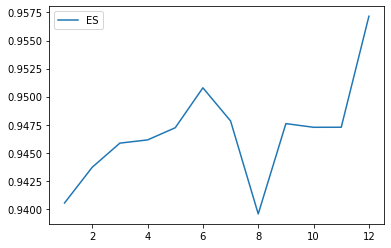

In [12]:
ES_df.plot()

In [13]:
ES_df.to_csv('energy_score_phase3_nogrid.csv')